In [1]:
from sklearn.externals import joblib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.animation import FuncAnimation


## Load model generated in previous notebook

In [2]:
model = joblib.load( 'model.pkl' )
dist_pickle = joblib.load( 'model.pkl' )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

## Multi window sliding and false positve fix

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


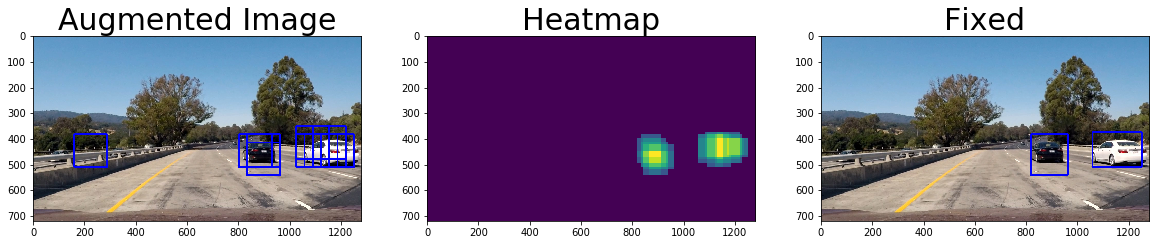

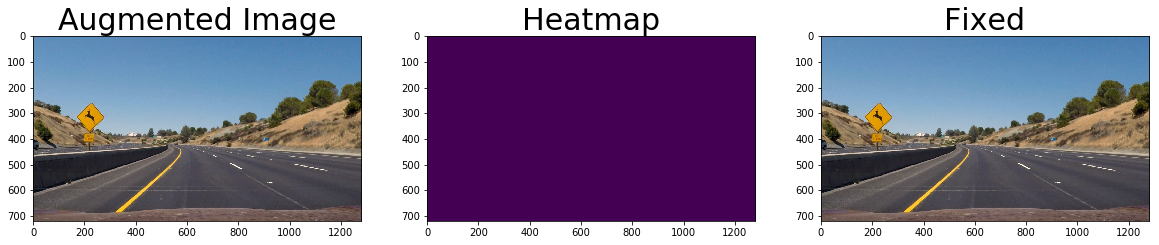

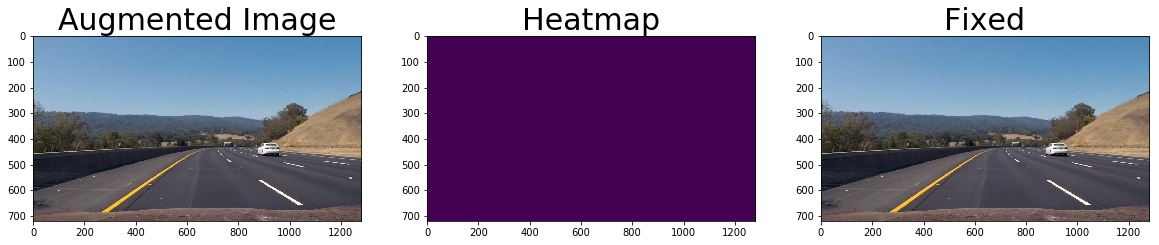

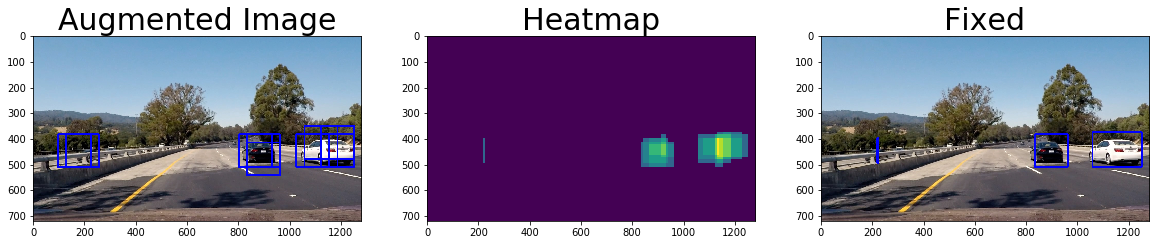

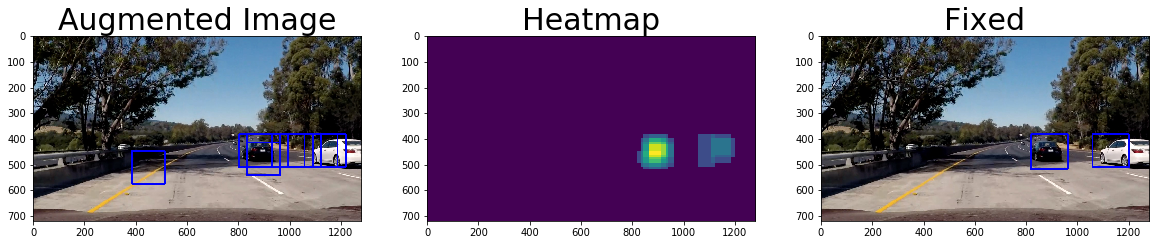

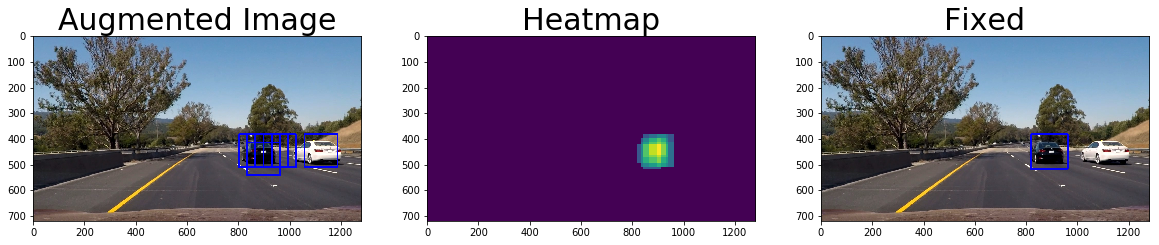

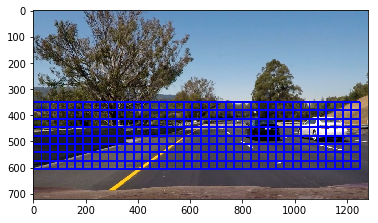

In [3]:
%matplotlib inline
import glob
from hog_subsample import find_cars 
from false_positives import add_heat, apply_threshold, draw_labeled_bboxes
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from lesson_functions import draw_boxes

def pipeline(img, return_heatmap=False):
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    ystart = 350
    ystop = 656
    box_list = []

    for scale in [1, 1.5, 2]:
        out_img, _list, allboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + _list
    
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if return_heatmap:
        return out_img, draw_img, heatmap, allboxes
    else:
        return draw_img

allboxes = False
for name in glob.glob( './test_images/*.jpg'):
    img = mpimg.imread(name)

    out_img, draw_img, heatmap, allboxes = pipeline(img, True)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    ax1.imshow(out_img)
    ax1.set_title('Augmented Image', fontsize=30)
    ax2.imshow(heatmap)
    ax2.set_title('Heatmap', fontsize=30)
    ax3.imshow( draw_img )
    ax3.set_title('Fixed', fontsize=30)

    plt.show()

plt.imshow(draw_boxes(img, allboxes))
plt.show()

## Augment Video

In [4]:
from moviepy.editor import VideoFileClip

output_file = './processed_project_video.mp4'
input_file = './project_video.mp4'
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(pipeline)
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [1:09:15<00:01,  1.56s/it]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

